In [1]:
%matplotlib inline 
import torch 
from torch import nn 
from d2l import torch as d2l

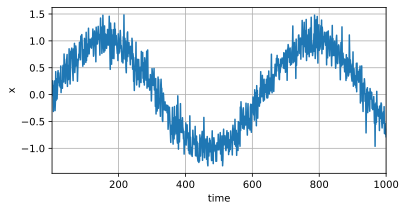

In [2]:
# 生成正弦函数+噪声的序列数据
T = 1000 # 总共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
# 构建模型的特征、标签
# 特征：待预测值的前4个值
# 标签：待预测值
tau = 4
features = torch.zeros((T-tau, tau))  # 丢弃前4项，相当于从第5项开始构建特征-标签对
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:].reshape((-1, 1))

In [13]:
# 数据集前600个样本作为训练集
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [14]:
# 构建神经网络模型

# 初始化网络权重的参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net 

# 平方损失注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none') # reduction='none'，返回每个样本的平方误差

In [16]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss) :f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.076943
epoch 2, loss: 0.057617
epoch 3, loss: 0.053083
epoch 4, loss: 0.051828
epoch 5, loss: 0.050437


预测

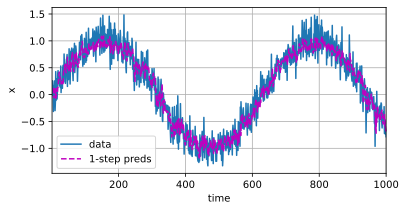

In [17]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

In [18]:
# k步预测
# 对训练集之后的样本假设未知，用预测值来进行多步预测
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau] # 前604样本已知
for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))

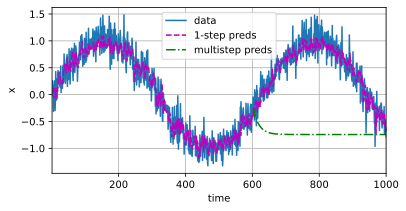

In [19]:
d2l.plot([time, time[tau:], time[n_train+tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train+tau:].detach().numpy()],
         'time', 'x', legend=['data', '1-step preds', 'multistep preds'], 
         xlim=[1, 1000], figsize=(6, 3))

In [20]:
max_steps = 64

In [ ]:
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))  # (933, 68), 从第68个样本开始
# 列i(i < tau)是来自x的观测，其时间步从(i+1)到(i+T-tau-max_steps+1)
for i in range(tau):
    features[:, i] = x[i: i+T-tau-max_steps+1]

# 列i(i >= tau)是来自(i-tau+1)步的预测，其时间步从(i+1)到(i+T-tau-max_steps+1)
for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1) # 用4列预测新值，并利用预测值继续预测接下来的值

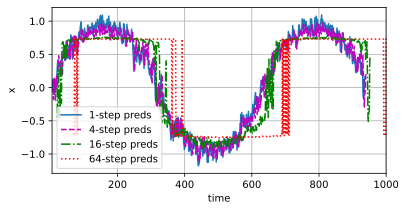

In [26]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps], 
         [features[:, (tau+i-1)].detach().numpy() for i in steps],
         'time', 'x', legend=[f'{i}-step preds' for i in steps],
         xlim=[5, 1000], figsize=(6, 3))